In [ ]:
# Team Deep Divers submission for
# Brown Data Science DATA2040 Deep Learning course. 
# Authors: Haoda Song, Siyuan Li, Yuyang Li

# The Kaggle notebook structure is based on the example created by Kaiwen Yang and Dr.Dan Potter

import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
import json
import tensorflow as tf
from functools import partial

import tensorflow.keras as keras
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
import cv2

# Exploratory Data Analysis

In [ ]:
train_labels = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
csv_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train_labels.head()

### Class0: Cassava Bacterial Blight (CBB)

In [ ]:
labels = pd.read_csv(os.path.join("../input/cassava-leaf-disease-classification/train.csv"))
sample0 = labels[labels.label == 0].sample(4)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample0.image_id, sample0.label)):
    plt.subplot(1, 4, ind + 1)
    img = cv2.imread(os.path.join('../input/cassava-leaf-disease-classification', "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.show()

### Class1: Cassava Brown Streak Disease (CBSD)

In [ ]:
sample1 = labels[labels.label == 1].sample(4)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample1.image_id, sample1.label)):
    plt.subplot(1, 4, ind + 1)
    img = cv2.imread(os.path.join('../input/cassava-leaf-disease-classification', "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.show()

### Class2: Cassava Green Mottle (CGM)

In [ ]:
sample2 = labels[labels.label == 2].sample(4)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample2.image_id, sample2.label)):
    plt.subplot(1, 4, ind + 1)
    img = cv2.imread(os.path.join('../input/cassava-leaf-disease-classification', "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.show()

### Class3: Cassava Mosaic Disease (CMD)

In [ ]:
sample3 = labels[labels.label == 3].sample(4)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample3.image_id, sample3.label)):
    plt.subplot(1, 4, ind + 1)
    img = cv2.imread(os.path.join('../input/cassava-leaf-disease-classification', "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.show()

### Class4: Healthy

In [ ]:
sample4 = labels[labels.label == 4].sample(4)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample4.image_id, sample4.label)):
    plt.subplot(1, 4, ind + 1)
    img = cv2.imread(os.path.join('../input/cassava-leaf-disease-classification', "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.show()

Citation: [Cassava Leaf Disease: Best Keras CNN](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn)

### Class Distributions

In [ ]:
train_labels['label']=train_labels['label'].astype(str)
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
  disease_dict = json.load(f)
disease_df = pd.DataFrame(list(disease_dict.items()),columns = ['label','real_label'])

for i in range(len(disease_df)):
  disease_df['label'][i] = int(i)

actual_class = pd.merge(csv_df,disease_df,on='label') 
#Count the number of images in each disease
obs_in_actual = actual_class.groupby(['label','real_label']).size()
print(obs_in_actual) 

In [ ]:
ax = (actual_class.value_counts(actual_class['real_label'], ascending=True)
                 .plot(kind='barh', fontsize="20", 
                       title="Class Distribution", figsize=(8,5)))

ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.title.set_size(15)
plt.show()

In [ ]:
# We calculated our baseline accuracy based on the calss with the largest proportion (class 3)
num_class3 = 13158
num_total = len(train_labels.label)
baseline_acc = num_class3/num_total
print("Baseline Accuracy:",baseline_acc) #0.6150

# TFRecord Data

We know the truth that Class Three have the much larger proportion than other classes so our data is imbalanced and our prediction would be biased if we only split the original data randomly. However, we cannot balance the tradeoffs between image resizing (256 x 256 and above) and handling imblanced images due to the limitations of RAM and the stratified method. Therefore, we used the Stratified data in TFRecords format generated by the Kagglor,DimitreOliveira. The details could be checked by the public notebook, [Cassava Leaf Disease-Stratified TFRecords 256x256](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-stratified-tfrecords-256x256).
This dataset contains 15 files with similar proportion of each class. Each file contains around 1427 eaxamples.

In [ ]:
#All files have the similar structures so we chose 12 files as training set and 3 files as validation set.
import glob
train_dir = '../input/stratifiedtf/StratifiedTF/train_newtf/*'
test_dir = '../input/stratifiedtf/StratifiedTF/val_newtf/*'
train_list = glob.glob(train_dir)
test_list = glob.glob(test_dir)
print("train: " + str(len(train_list)) + "\ntest: " + str(len(test_list)))

In [ ]:
#Read TFrecords
#the functions are adapted from the examples provided by keras reference site: 
#https://keras.io/examples/keras_recipes/tfrecord/
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    dataset=dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [256, 256]

dataset_train=load_dataset(train_list,labeled=True)
dataset_val=load_dataset(test_list,labeled=True)

In [ ]:
labels = train_labels
DATASET_SIZE=len(labels)
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
print("Training data size:",train_size)
print("Validation data size:",val_size)

# Models

We implemented four different models, including our baseline CNN model, ResNet50, ResNet architecture, self-designed (ResNet + VGG architechture) and EfficientNet B0. Our results shows EfficientNetB0 gives the best accuracy as well as the best training performance.

## Baseline CNN Model

In [ ]:
def build_baseline():
    inputs = Input(shape = (256,256,3))
    
    model = Conv2D(filters=32, kernel_size=(3, 3),activation='relu',
                   input_shape=(256,256,3))(inputs)
    model = AveragePooling2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(model)
    model = AveragePooling2D(pool_size=(2, 2))(model)
    model = Dropout(0.5)(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(model)
    model = Dropout(0.5)(model)
    
    model = Flatten()(model)
    model = Dense(512, activation = "relu")(model)
    out = Dense(5, activation = 'softmax')(model)
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=["sparse_categorical_accuracy"])
    return model

In [ ]:
model = build_baseline()
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 5, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

history = model.fit(
    dataset_train.repeat(),
    steps_per_epoch = train_size//BATCH_SIZE,
    validation_data= dataset_val.repeat(),
    validation_steps=val_size//BATCH_SIZE,
    epochs=20,
    callbacks = [early_stop, reduce_lr],
    verbose=True
)

In [ ]:
import matplotlib.pyplot as plt
N = 9
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Baseline CNN Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

For our baseline CNN model, overfitting occurs at epoch 5 due to the trends of training and validation losses. Therefore, the baseline CNN achieved 0.66 validation accuracy. We hope the further models would make improvements.

In [ ]:
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [ ]:
save_model(model, 'baseCNN_model') #save baseline CNN model

## Self-Designed (ResNet + VGG architechture)

In [ ]:
#The functions are written by 
#https://colab.research.google.com/github/d2l-ai/d2l-tensorflow-colab/blob/master/chapter_convolutional-modern/resnet.ipynb
!pip install d2l==0.16.1
from d2l import tensorflow as d2l
import tensorflow as tf

class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X   

In [ ]:
sd_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),

        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),

        tf.keras.layers.Conv2D(128, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(256, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=7, strides=2, padding='same'),

        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=5, activation="softmax")])

In [ ]:
sd_model.summary()

In [ ]:
sd_model.compile(loss='sparse_categorical_crossentropy',
          optimizer=keras.optimizers.Adam(lr=0.0001),
          metrics=['sparse_categorical_accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 5, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

sd_history = sd_model.fit(
    dataset_train.repeat(), 
    steps_per_epoch = train_size//BATCH_SIZE,
    validation_data = dataset_val.repeat(), 
    validation_steps= val_size//BATCH_SIZE,
    callbacks=[reduce_lr, early_stop],
    epochs = 20,
    verbose = True)

In [ ]:
import matplotlib.pyplot as plt
N = 7
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), sd_history.history["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), sd_history.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), sd_history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), sd_history.history["val_loss"], label="Validation Loss")
plt.title("Self-Designed Model Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Our self-designed model which combines Residual blocks and VGG architectures performs better than our baseline CNN model. This model gives us 0.689 as the best validation accuracy at epoch 4 and then overfitting happens due to the trends of training and validation losses.

## ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

base_res = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

head_res = base_res.output
head_res = GlobalAveragePooling2D()(head_res)
head_res = Dense(5, activation= "softmax")(head_res)
resnet50 = Model(inputs=base_res.input, outputs=head_res)

In [ ]:
for layer in base_res.layers:
  layer.trainable = False

In [ ]:
resnet50.summary()

In [ ]:
resnet50.compile(optimizer = Adam(lr = 0.01),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 5, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)

history_resnet50 = resnet50.fit(
    dataset_train.repeat(),
    steps_per_epoch = train_size//BATCH_SIZE,
    validation_data= dataset_val.repeat(),
    validation_steps=val_size//BATCH_SIZE,
    epochs=30,
    callbacks = [reduce_lr, early_stop],
    verbose=True
)

In [ ]:
N = 29
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_resnet50.history["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_resnet50.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history_resnet50.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_resnet50.history["val_loss"], label="Validation Loss")
plt.title("ResNet50 Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

At epoch 18 and later, the validation accuracy converges to 0.64. It means the model based on pre-trained ResNet50 performs worse than our baseline CNN model and we decided to swich on other models. 

## ResNet architecture

In [ ]:
resarc = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256,256,3)),
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
    
    ResnetBlock(64, 2, first_block=True),
    ResnetBlock(128, 2),
    ResnetBlock(256, 2),
    ResnetBlock(512, 2),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(units=5, activation="softmax")])

In [ ]:
resarc.summary()

In [ ]:
resarc.compile(optimizer = Adam(lr = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

history_resarc = resarc.fit(
    dataset_train.repeat(),
    steps_per_epoch = train_size//BATCH_SIZE,
    validation_data= dataset_val.repeat(),
    validation_steps=val_size//BATCH_SIZE,
    epochs=20,
    callbacks = [reduce_lr, early_stop],
    verbose=True
)

In [ ]:
N = 16
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_resarc.history["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_resarc.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history_resarc.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_resarc.history["val_loss"], label="Validation Loss")
plt.title("ResNet(Arc) Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

The simple ResNet architecture achieves 0.67 accuracy which is higher than baseline accuracy (0.6150) but the improvement is not big enough to conclude the final model. At the epoch 8, the model begins to overfit the training dataset.

## EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
effb0_model = tf.keras.Sequential()
effb0_model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                          input_shape = (256, 256, 3)))

effb0_model.add(tf.keras.layers.GlobalAveragePooling2D())
effb0_model.add(tf.keras.layers.Dense(5, activation = "softmax"))

effb0_model.compile(optimizer = Adam(lr = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
effb0_model.summary()

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
#                               patience = 5, min_delta = 0.001, 
#                               mode = 'min', verbose = 1)

# early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
#                            patience = 10, mode = 'min', verbose = 1,
#                            restore_best_weights = True)

# history_effb0 = effb0_model.fit(
#     dataset_train.repeat(),
#     steps_per_epoch = train_size//BATCH_SIZE,
#     validation_data= dataset_val.repeat(),
#     validation_steps=val_size//BATCH_SIZE,
#     epochs=100,
#     callbacks = [reduce_lr, early_stop],
#     verbose=True
# )

In [ ]:
#Import the local trained EfficientNetB0 model.
effnetb0 = keras.models.load_model("../input/effnetb0/EffNetB0.h5")

EffNetb0.png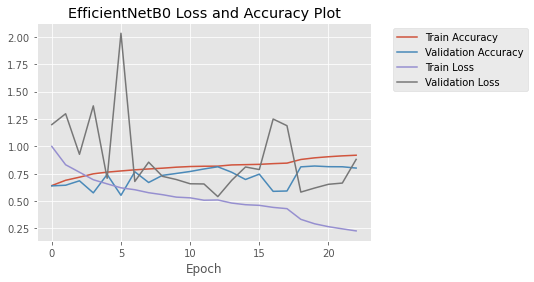

EfficientNetB0 gives us around 0.8 validation accuracy score (Within the range: 0.79 - 0.82). Comparing to our baeline model, EfficientNetB0 improved 0.185 validation accuracy with an excellent training process. Therefore, we decided to use the EfficientNet50 as our final model to make the prediction on test set.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import smart_resize

preds = []
sample_sub = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv')

for image in sample_sub.image_id:
    img = keras.preprocessing.image.load_img('/kaggle/input/cassava-leaf-disease-classification/test_images/' + image)
    img = img_to_array(img)
    img = smart_resize(img, (256,256))
    img = tf.reshape(img, (-1, 256, 256, 3))
    
    # Now apply your model and save your prediction:
    prediction = effnetb0.predict(img)
    preds.append(np.argmax(prediction))
    

my_submission = pd.DataFrame({'image_id': sample_sub.image_id, 'label': preds})
my_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [ ]:
sample_submission=pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
sample_submission #True label

In [ ]:
submission=pd.read_csv("./submission.csv")
submission #Predicted Label